In [1]:
import pandas as pd
import torch
import numpy as np
import scipy
from sklearn import metrics
import matplotlib.pyplot as plt
import random

In [2]:
data_path = './data'

In [3]:
train_df = pd.read_csv(f'{data_path}/PAIRS (train).csv')
dev_df = pd.read_csv(f'{data_path}/PAIRS (dev).csv')
test_df = pd.read_csv(f'{data_path}/PAIRS (test).csv')

In [4]:
label_columns = 'similarity_empathy_human_AGG	similarity_event_human_AGG	similarity_emotion_human_AGG	similarity_moral_human_AGG'.split()

In [5]:
text_preprocess = lambda x:x.strip().replace('\n',' ')

In [6]:
# Choose which two columns are used as text pairs

# text_columns = ['story_A', 'story_B']
text_columns = ['story_A_summary', 'story_B_summary']
label_column = [label_columns[0]]

In [7]:
score_conversion_funcs = {
    "original_paper": lambda x: x / 4,
    "01_continue": lambda x:(x - 1) / 3,
}
score_recover_funcs = {
    "original_paper": lambda x: x * 4,
    "01_continue": lambda x:(x * 3) + 1,
}

In [8]:
# Choose score conversion method
score_conversion_in_use = "01_continue"

In [9]:
score_conversion_func = score_conversion_funcs.get(score_conversion_in_use)
score_recover_func = score_recover_funcs.get(score_conversion_in_use)

In [10]:
def create_data(df, text_pps, score_conversion_funcs):
    required_columns = text_columns + label_column
    df = df[required_columns].rename(columns={ k:v for k,v in zip(required_columns,['sentence1', 'sentence2','score'])})
    for i in [1,2]:
        df[f'sentence{i}'] = df[f'sentence{i}'].apply(text_pps)
    df['score'] = score_conversion_funcs(df['score'])
    return df

In [11]:
train_df = create_data(train_df, text_preprocess, score_conversion_func)
dev_df = create_data(dev_df, text_preprocess, score_conversion_func)
test_df = create_data(test_df, text_preprocess, score_conversion_func)

In [12]:
from torch.utils.data import DataLoader
import math
from sentence_transformers import models, losses, datasets,  util
from sentence_transformers import LoggingHandler, SentenceTransformer, util, InputExample
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
import logging
from datetime import datetime

In [13]:
# model_name = "sentence-transformers/multi-qa-mpnet-base-dot-v1"
model_name = "FacebookAI/roberta-large"
train_batch_size = 64
num_epochs = 3
max_seq_length = 512

In [14]:
word_embedding_model = models.Transformer(model_name, max_seq_length=max_seq_length)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
model_save_path = "./contrastive_exp/"

In [16]:
!rm {model_save_path}/* -rf

In [17]:
train_data = train_df.to_dict(orient='records')

In [18]:
bin_threshold = train_df['score'].median()

In [19]:
label2id = { k:v for v,k in enumerate(sorted(score_recover_func(train_df['score'].sort_values().unique()).tolist()))}

In [20]:
label_conversion = {
    "none": lambda x:x,
    "binned": lambda x: int(x > bin_threshold),
    "class": lambda x: label2id[score_recover_func(x)]
}

In [21]:
def build_similarity_base(threshold):
    similarity_base = {}
    for data in train_data:
        s1, s2, score = list(data.values())
        if s1 not in similarity_base:
            similarity_base[s1] = {"positive":set(),  "negative":set()}
        if s2 not in similarity_base:
            similarity_base[s2] = {"positive":set(),  "negative":set()}
        if score <= threshold:
            similarity_base[s1]['negative'].add(s2)
            similarity_base[s2]['negative'].add(s1)
        if score > threshold:
            similarity_base[s1]['positive'].add(s2)
            similarity_base[s2]['positive'].add(s1)  
    return similarity_base

In [22]:
similarity_base = build_similarity_base(bin_threshold)

In [23]:
def select_triple_component(s1, s2, score, label_transform):
    if score > bin_threshold:
        hard_neg_set = similarity_base[s1]['negative'] | similarity_base[s2]['negative']
        if len(hard_neg_set) == 0:
            hard_neg_set = similarity_base.keys()
        hard_neg = random.choice(list(hard_neg_set))
        return [
            InputExample(texts=[s1, s2, hard_neg], label=label_transform(score)), 
            InputExample(texts=[s2, s1, hard_neg], label=label_transform(score))
        ]
    else:
        s1_pos_set = similarity_base[s1]['positive'] 
        pos = s1
        if len(s1_pos_set) > 0:
            pos = random.choice(list(s1_pos_set))
            return [
                InputExample(texts=[s1, pos, s2], label=label_transform(score)), 
                InputExample(texts=[pos, s1, s2], label=label_transform(score))
            ]
        else:
            return [InputExample(texts=[s1, pos, s2], label=label_transform(score))]

In [24]:
available_loss_functions = {
    'MultipleNegativesRankingLoss': (
        losses.MultipleNegativesRankingLoss(model,scale=1.0),
        label_conversion.get('none')
    ),
    'TripletLoss': (
        losses.TripletLoss(model,triplet_margin=5),
        label_conversion.get('none')
    ),
}

In [25]:
# Choose loss
loss_in_use = "MultipleNegativesRankingLoss"

In [26]:
loss_func, label_transform = available_loss_functions.get(loss_in_use)

In [27]:
train_samples = []
for x in train_data:
    s1,s2,score = list(x.values())
    components = select_triple_component(s1, s2, score, label_transform)
    train_samples.extend(components)


In [28]:
train_dataloader = datasets.NoDuplicatesDataLoader(train_samples, batch_size=train_batch_size)

In [29]:
dev_data = dev_df.to_dict(orient='records')

In [30]:
dev_samples = []
for x in dev_data:
    s1,s2,score = list(x.values())
    dev_samples.append(InputExample(texts=[s1, s2], label=score))

In [31]:
test_data = test_df.to_dict(orient='records')

In [32]:
test_samples = []
for x in test_data:
    s1,s2,score = list(x.values())
    test_samples.append(InputExample(texts=[s1, s2], label=score))

In [33]:
dev_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(
    dev_samples, batch_size=train_batch_size, name="emp-dev"
)
test_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(
    test_samples, batch_size=train_batch_size, name="emp-test"
)


In [34]:
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.3)

In [35]:
warmup_steps

38

In [36]:
len(train_dataloader)

42

In [37]:
int(len(train_dataloader) * 10)

420

In [38]:
# Train the model
model.fit(
    train_objectives=[(train_dataloader, loss_func)],
    evaluator=dev_evaluator,
    epochs=num_epochs,
    evaluation_steps=15,
    warmup_steps=warmup_steps,
    output_path=model_save_path,
    use_amp=True,  # Set to True, if your GPU supports FP16 operations
)


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/42 [00:00<?, ?it/s]

Iteration:   0%|          | 0/42 [00:00<?, ?it/s]

Iteration:   0%|          | 0/42 [00:00<?, ?it/s]

In [39]:
def eval_final(data_split, evaluator, score_recover_func, split_name='dev'):
    evaluator(model, model_save_path)
    output_name = !ls {model_save_path}/similarity_evaluation_emp-{split_name}_results.csv
    sp_df = pd.read_csv(output_name[0])['cosine_pearson	cosine_spearman'.split()]
    s1 = list(map(lambda x:x['sentence1'], data_split))
    s2 = list(map(lambda x:x['sentence2'], data_split))
    score = list(map(lambda x:x['score'], data_split))
    bin_labels = (score_recover_func(np.array(score)) >2.5).astype(np.int64)
    s1_embeddings = model.encode(s1)
    s2_embeddings = model.encode(s2)
    predicted_cosine_scores = util.pairwise_cos_sim(s1_embeddings, s2_embeddings)
    s = scipy.stats.spearmanr(score, predicted_cosine_scores.numpy())
    p = scipy.stats.pearsonr(score, predicted_cosine_scores.numpy())
    pred_labels = (score_recover_func(predicted_cosine_scores) >2.5).long().numpy()
    cls_df = pd.DataFrame(metrics.classification_report(bin_labels, pred_labels,output_dict=True)).T
    return cls_df, sp_df, predicted_cosine_scores, score, pred_labels, bin_labels

In [40]:
dev_cls_df, dev_sp_df, predicted_dev_scores, dev_score, pred_dev_labels, gt_dev_labels = eval_final(dev_data, dev_evaluator, score_recover_func, split_name='dev')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [41]:
test_cls_df, test_sp_df, predicted_test_scores, test_score, pred_test_labels, gt_test_labels = eval_final(test_data, test_evaluator, score_recover_func, split_name='test')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [42]:
dev_sp_df

,cosine_pearson,cosine_spearman
0,0.420966,0.401462


In [43]:
dev_cls_df

,precision,recall,f1-score,support
0,0.779661,0.741935,0.760331,62.00
1,0.609756,0.657895,0.632911,38.00
accuracy,0.710000,0.710000,0.710000,0.71
macro avg,0.694709,0.699915,0.696621,100.00
weighted avg,0.715097,0.710000,0.711911,100.00


In [44]:
test_sp_df

,cosine_pearson,cosine_spearman
0,0.361585,0.358364


In [45]:
test_cls_df

,precision,recall,f1-score,support
0,0.634286,0.569231,0.600000,195.00
1,0.626667,0.687805,0.655814,205.00
accuracy,0.630000,0.630000,0.630000,0.63
macro avg,0.630476,0.628518,0.627907,400.00
weighted avg,0.630381,0.630000,0.628605,400.00


(array([ 7.,  7., 19., 43., 50., 87., 79., 64., 34., 10.]),
 array([-0.03873561,  0.05790433,  0.15454426,  0.25118423,  0.34782416,
         0.44446409,  0.54110402,  0.63774395,  0.73438394,  0.83102387,
         0.9276638 ]),
 <BarContainer object of 10 artists>)

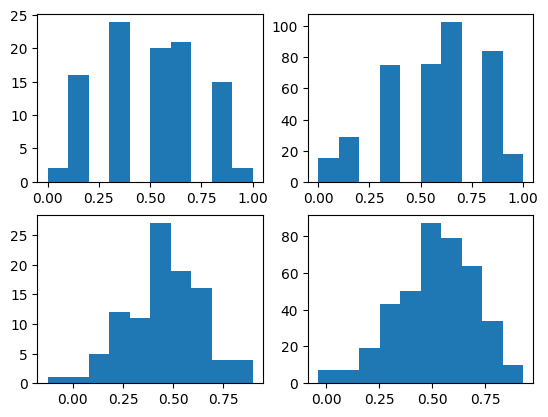

In [46]:
fig,axs = plt.subplots(2,2)
axs[0,0].hist(dev_score)
axs[0,1].hist(test_score)
axs[1,0].hist(predicted_dev_scores)
axs[1,1].hist(predicted_test_scores)